In [22]:
import pandas as pd
import numpy as np
import json
import re
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [17]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

### Load dataset

In [6]:
data = pd.read_csv('../full_marked_dataset.csv')
del data['Unnamed: 0']
data = data[data['ans'] != 'неизвестно']
data.head()

,text,ans
0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,спорт
1,\t1.2. На концерте в летнем лагере ребята игра...,музыка
3,\t1.4. Во время летних соревнований по плавани...,спорт
4,\t1.5. В спортивную школу во время летних кани...,спорт
6,\t1.7. Самые крупные животные на нашей планете...,животные


### Train tf-idf + logistic regression

In [15]:
import logistic_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [7]:
preparator = logistic_regression.LogicticRegressionPreparator() # Подгружаем модуль для обработки текстов
y = data['ans'].values
X = preparator.prepare_texts(data['text'].values) # Делаем обработку текстов для дальнейшего обучения

100%|██████████| 727/727 [00:01<00:00, 413.87it/s]


In [9]:
# Делим данные на валидационные и тренировочные
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_val))

581 146


In [31]:
model = logistic_regression.LogicticRegressionModel(pretrained=False) # Создаем модель для обучения
model.fit(X_train , y_train) # Обучаем

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 5
iter   7  #CD cycles 1
iter   8  #CD cycles 30
iter   9  #CD cycles 5
iter  10  #CD cycles 1
iter  11  #CD cycles 40
iter  12  #CD cycles 5
iter  13  #CD cycles 1
iter  14  #CD cycles 27
iter  15  #CD cycles 1
iter  16  #CD cycles 34
optimization finished, #iter = 16
Objective value = 2189.143623
#nonzeros/#features = 319/2039
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 5
iter   7  #CD cycles 1
iter   8  #CD cycles 39
iter   9  #CD cycles 4
iter  10  #CD cycles 1
iter  11  #CD cycles 16
iter  12  #CD cycles 1
iter  13  #CD cycles 18
optimization finished, #iter = 13
Objective value = 2090.648578
#nonzeros/#features = 278/2039
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  

Precision:   0.52
Recall:   0.55
F1-measure:   0.54
Accuracy:   0.72
              precision    recall  f1-score   support

    животные       0.77      0.75      0.76        71
  литература       0.70      0.71      0.70        52
      музыка       0.00      0.00      0.00         3
       спорт       0.62      0.75      0.68        20

    accuracy                           0.72       146
   macro avg       0.52      0.55      0.54       146
weighted avg       0.71      0.72      0.71       146



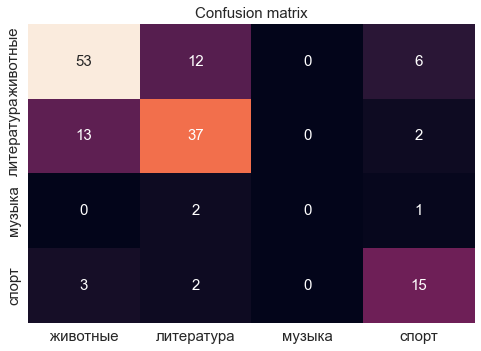

In [32]:
predictions = model.predict(X_val)
print("Precision: {0:6.2f}".format(precision_score(y_val, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_val, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_val, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_val, predictions)))
print(classification_report(y_val, predictions))
labels = model.classes
sns.heatmap(data=confusion_matrix(y_val, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

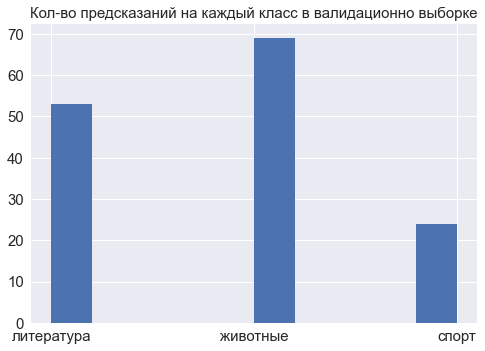

In [42]:
plt.hist(predictions)
plt.title('Кол-во предсказаний на каждый класс в валидационно выборке')
plt.show()

In [34]:
model.save() # Сохраняем модель по дефолтному пути

### Using model for making submit

In [30]:
import importlib
importlib.reload(logistic_regression)

[nltk_data] Downloading package stopwords to /home/sergak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sergak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<module 'logistic_regression' from '/home/sergak/Documents/Neyro_sets/AIIJC/EduRu/Sergey/logistic_regression.py'>

In [35]:
model = logistic_regression.LogicticRegressionModel(pretrained=True) # Подгружаем предобученную модель
preparator = logistic_regression.LogicticRegressionPreparator() # Подгружаем модуль для обработки текстов

In [39]:
test_df = pd.read_csv('../test.csv') # Считываем данные
test_df['prepared'] = preparator.prepare_texts(test_df['task']) # Делаем необходимую обработку текстов

100%|██████████| 514/514 [00:03<00:00, 141.89it/s]


In [40]:
test_df['category'] = model.predict(test_df['prepared']) # Предсказываем категории
test_df['keywords'] = ['; '.join(model.get_top_words(text))
                    for text in test_df['prepared']] # Предсказываем ключчевые слова
test_df = test_df.drop(['task', 'prepared'], axis = 1) # Убираем ненужные столбцы
test_df.head()

,id,category,keywords
0,0,спорт,
1,1,литература,ящик; собака
2,2,спорт,год
3,3,литература,
4,4,литература,вид; рисунок


In [41]:
test_df.to_csv('sabmit_log_reg.csv')